<a href="https://colab.research.google.com/github/MiguelAngeloTr/BIGDATA/blob/main/C3/ProyectoFinal/knn_svm_regressor_pyspark_bigdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pyspark
!pip install -q findspark
!pip install -q dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype

from pyspark.sql import SparkSession
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T

from dask_ml.model_selection import GridSearchCV, RandomizedSearchCV
from dask.distributed import Client

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

In [ ]:
spark = SparkSession.builder.appName("KNN - SVM Regression PySpark").getOrCreate()
spark

In [ ]:
client = Client(n_workers=4, threads_per_worker=4)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35205
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33007'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39979'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37569'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40559'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:41525', name: 3, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41525
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:37206
INFO:distributed.scheduler:Regist

In [ ]:
url = 'https://raw.githubusercontent.com/SantiagoMorenoV/Combined-Cycle-Power-Plant_Regs/refs/heads/main/Data.csv'
spark.sparkContext.addFile(url)
datos = spark.read.csv(SparkFiles.get('Data.csv'),inferSchema=True, header=True)
datos.show(5, truncate=False)

+-----+-----+-------+-----+------+
|AT   |V    |AP     |RH   |PE    |
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
|5.11 |39.4 |1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82|37.5 |1009.23|96.62|473.9 |
+-----+-----+-------+-----+------+
only showing top 5 rows



In [ ]:
datos.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)



#Informacion Faltante y Columnas innecesarias


In [ ]:
datos_f1 = datos.drop("_c0")
datos_f1.show(5, truncate=False)

+-----+-----+-------+-----+------+
|AT   |V    |AP     |RH   |PE    |
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
|5.11 |39.4 |1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82|37.5 |1009.23|96.62|473.9 |
+-----+-----+-------+-----+------+
only showing top 5 rows



In [ ]:
def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()

In [ ]:
faltantes(datos_f1)

+---+---+---+---+---+
| AT|  V| AP| RH| PE|
+---+---+---+---+---+
|  0|  0|  0|  0|  0|
+---+---+---+---+---+



# Analisis Exploratorio de Datos (EDA)

In [ ]:
numeric_features = [t[0] for t in datos_f1.dtypes if t[1] == 'int' or t[1] == 'double']
datos_f1.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
AT,9568,19.65123118729102,7.4524732296110825,1.81,37.11
V,9568,54.30580372073601,12.707892998326784,25.36,81.56
AP,9568,1013.2590781772603,5.938783705811581,992.89,1033.3
RH,9568,73.30897784280926,14.600268756728964,25.56,100.16
PE,9568,454.3650094063554,17.066994999803402,420.26,495.76


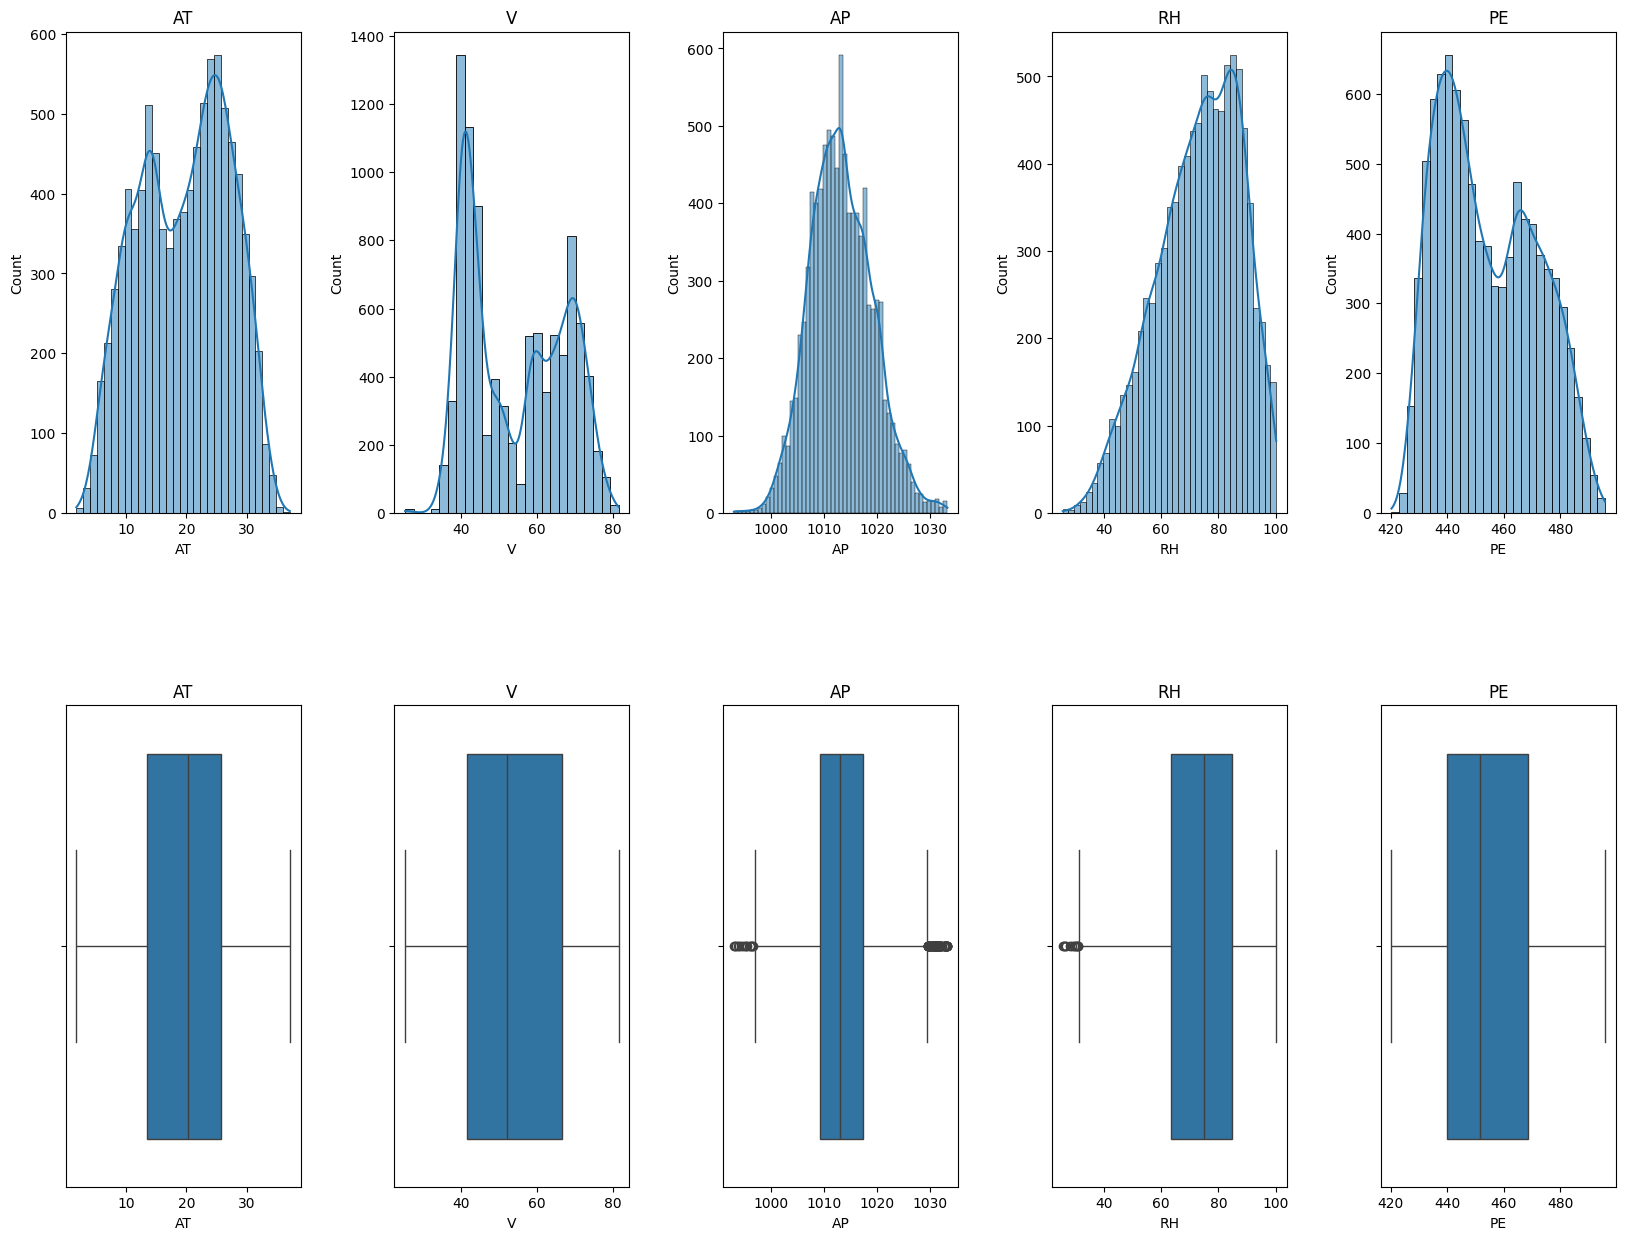

In [ ]:
datos_EDA = datos_f1.toPandas()
num_list = []
cat_list = []

fig, axes = plt.subplots(2, len(datos_EDA.columns), figsize=(20, 15))  # Ajusta el tamaño según sea necesario
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

# Contador para los gráficos
graph_count = 0

# Iterar sobre las columnas del DataFrame
for column in datos_EDA.columns:
    if is_numeric_dtype(datos_EDA[column]):
        # Histograma en la primera fila
        sns.histplot(datos_EDA[column], kde=True, ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")

        # Boxplot en la segunda fila
        sns.boxplot(x=datos_EDA[column], ax=axes[graph_count + len(datos_EDA.columns)])
        axes[graph_count + len(datos_EDA.columns)].set_title(f"{column}")
        num_list.append(column)
        graph_count += 1  # Pasar al siguiente gráfico

    elif is_string_dtype(datos_EDA[column]):
        sns.countplot(data=datos_EDA, x=datos_EDA[column], ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")
        cat_list.append(column)
        axes[graph_count + len(datos_EDA.columns)].axis("off")
        graph_count += 1  # Pasar al siguiente gráfico

# Mostrar la gráfica
plt.show()

<Axes: >

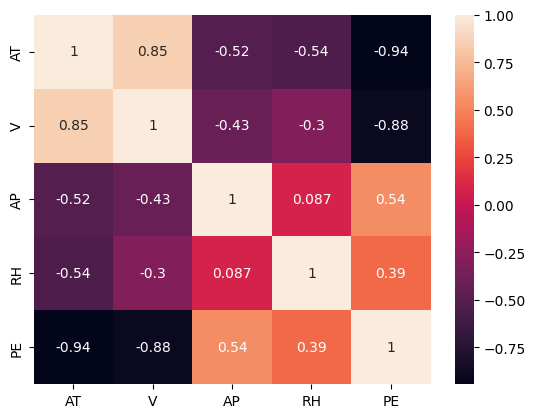

In [ ]:
sns.heatmap(datos_f1.toPandas().corr('spearman'),annot=True)

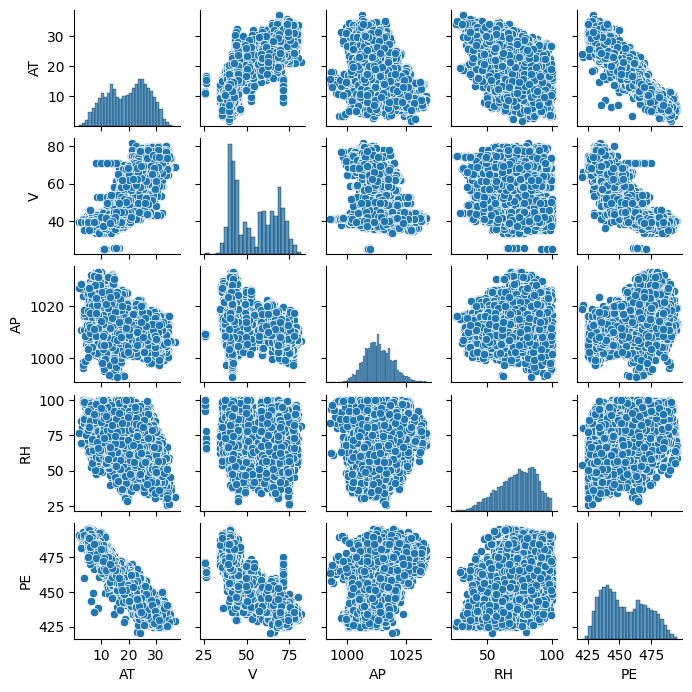

In [ ]:
sns.pairplot(datos_EDA, height=1.4)
plt.show()

In [ ]:
datos_f2 = datos_f1.select('AT','V','PE')
cols = datos_f2.columns
datos_f2.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- PE: double (nullable = true)



# Construcción del Regresor

In [ ]:
salida = 'PE'
caracteristicas = [car for car in cols if car not in salida]
cat_car = [c for c, t in datos_f2.dtypes if t == 'string' and c not in salida]
num_car = [c for c, t in datos_f2.dtypes if t in ['int', 'double'] and c not in salida]
print('Cat:',cat_car,'\nNum:', num_car)

Cat: [] 
Num: ['AT', 'V']


In [ ]:
indexers = [StringIndexer(inputCol = col,
                          outputCol = "c_{}".format(col)) for col in cat_car]

encoders = [OneHotEncoder(inputCol = "c_{}".format(col),
                          outputCol = "o_{}".format(col)) for col in cat_car]

assembler = VectorAssembler(inputCols = num_car + ["o_{}".format(col) for col in cat_car], outputCol = "features")

preprocessor = Pipeline(stages = indexers + encoders + [assembler]).fit(datos_f1)

In [ ]:
datos_f3 = preprocessor.transform(datos_f2)
selectedCols = [salida, 'features'] #+ cols
datos_f4 = datos_f3.select(selectedCols)
datos_f4.printSchema()

root
 |-- PE: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
datos_f4.show(truncate=False)

+------+-------------+
|PE    |features     |
+------+-------------+
|463.26|[14.96,41.76]|
|444.37|[25.18,62.96]|
|488.56|[5.11,39.4]  |
|446.48|[20.86,57.32]|
|473.9 |[10.82,37.5] |
|443.67|[26.27,59.44]|
|467.35|[15.89,43.96]|
|478.42|[9.48,44.71] |
|475.98|[14.64,45.0] |
|477.5 |[11.74,43.56]|
|453.02|[17.99,43.72]|
|453.99|[20.14,46.93]|
|440.29|[24.34,73.5] |
|451.28|[25.71,58.59]|
|433.99|[26.19,69.34]|
|462.19|[21.42,43.79]|
|467.54|[18.21,45.0] |
|477.2 |[11.04,41.74]|
|459.85|[14.45,52.75]|
|464.3 |[13.97,38.47]|
+------+-------------+
only showing top 20 rows



## Normalización o estandarización de variables


In [ ]:
#scaler = MinMaxScaler(inputCol='Regresor', min=-1,max=1,outputCol='ScaledReg')
#scaler = StandardScaler(inputCol='Regresor', outputCol='ScaledReg', withMean=True, withStd=True)
#scaler_model = scaler.fit(output)
#output = scaler_model.transform(output)

## División de conjuntos de ajuste (entrenamiento) y prueba

In [ ]:
train, test = datos_f4.randomSplit([0.8, 0.2], seed = 2024)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7683
Test Dataset Count: 1885


In [ ]:
train.describe().show(truncate=False)
test.describe().show(truncate=False)

+-------+------------------+
|summary|PE                |
+-------+------------------+
|count  |7683              |
|mean   |454.39687491865106|
|stddev |17.000969415315993|
|min    |420.26            |
|max    |495.35            |
+-------+------------------+

+-------+------------------+
|summary|PE                |
+-------+------------------+
|count  |1885              |
|mean   |454.2351299734756 |
|stddev |17.337463787423967|
|min    |425.11            |
|max    |495.76            |
+-------+------------------+



In [ ]:
train = train.select("features", salida).toPandas()
test = test.select("features", salida).toPandas()

In [ ]:
X_train = pd.DataFrame(train["features"].tolist(), columns=cols[:-1])
X_test = pd.DataFrame(test["features"].tolist(), columns=cols[:-1])
y_train, y_test = train[salida], test[salida]

#SVR

In [ ]:
reg_SVR = SVR()
param_grid = {"C": [0.01, 0.1, 1.0, 3.0, 10.0],
              "kernel": ["rbf", "poly", "sigmoid", "linear"]
              }

In [ ]:
gs_SVR = RandomizedSearchCV(reg_SVR, param_grid, n_iter=20, scheduler=client, random_state=42).fit(X_train, y_train)
print("Mejores hiperparámetros:", gs_SVR.best_params_)

Mejores hiperparámetros: {'kernel': 'linear', 'C': 3.0}


# KNN

In [ ]:
reg_KNN = KNeighborsRegressor()
param_grid = {"n_neighbors": range(3,20),
              "p":[1,2],
              "metric":['euclidean','minkowski']}

In [ ]:
gs_KNN = RandomizedSearchCV(reg_KNN, param_grid, n_iter=15, scheduler=client, random_state=42).fit(X_train, y_train)
print("Mejores hiperparámetros:", gs_KNN.best_params_)

Mejores hiperparámetros: {'p': 2, 'n_neighbors': 18, 'metric': 'minkowski'}


# Validación

In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    r2 = r2_score(y_true, y_pred)*100

    return {
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2 (%)": round(r2, 2),
        "MAPE (%)": round(mape, 2)
    }


In [ ]:
test_res_SVR, train_res_KNN = gs_SVR.predict(X_test), gs_KNN.predict(X_train)
train_res_SVR, test_res_KNN = gs_SVR.predict(X_train), gs_KNN.predict(X_test)

## Métricas de Rendimiento

### Entrenamiento

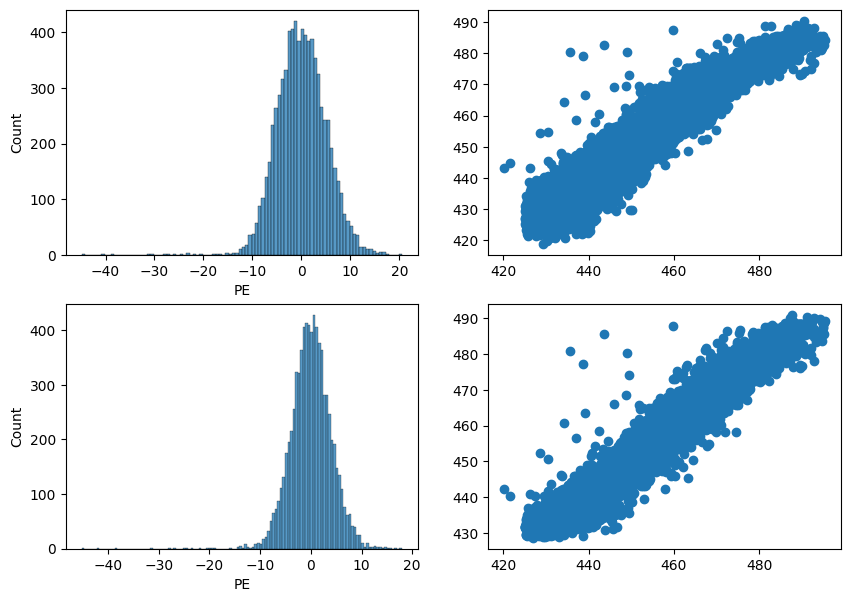

In [ ]:
plt.figure(column, figsize=(10,7))
plt.subplot(2, 2, 1)
sns.histplot(y_train-train_res_SVR)
plt.subplot(2, 2, 2)
plt.scatter(y_train, train_res_SVR)
plt.subplot(2, 2, 3)
sns.histplot(y_train - train_res_KNN)
plt.subplot(2, 2, 4)
plt.scatter(y_train, train_res_KNN)
plt.show()

In [ ]:
print("Métricas en datos de entrenamiento (SVR):\n")
train_metrics = calculate_metrics(y_train, train_res_SVR)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

print("\nMétricas en datos de entrenamiento (KNN):\n")
train_metrics = calculate_metrics(y_train, train_res_KNN)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de entrenamiento (SVR):

MSE: 25.09
RMSE: 5.01
MAE: 3.92
R2 (%): 91.32
MAPE (%): 0.87

Métricas en datos de entrenamiento (KNN):

MSE: 16.59
RMSE: 4.07
MAE: 3.08
R2 (%): 94.26
MAPE (%): 0.68


### Prueba

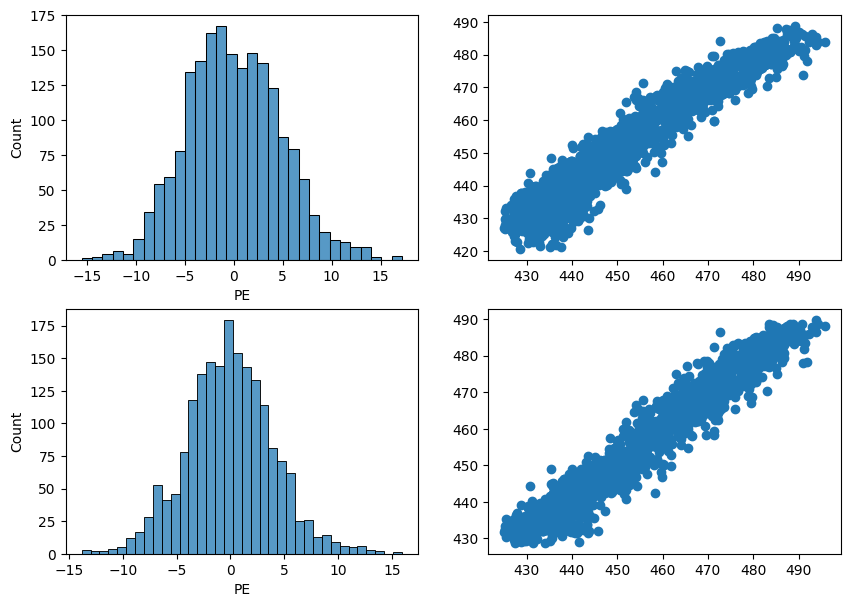

In [ ]:
plt.figure(column, figsize=(10,7))
plt.subplot(2, 2, 1)
sns.histplot(y_test-test_res_SVR)
plt.subplot(2, 2, 2)
plt.scatter(y_test, test_res_SVR)
plt.subplot(2, 2, 3)
sns.histplot(y_test - test_res_KNN)
plt.subplot(2, 2, 4)
plt.scatter(y_test, test_res_KNN)
plt.show()

In [ ]:
print("Métricas en datos de prueba (SVR):\n")
train_metrics = calculate_metrics(y_test, test_res_SVR)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

print("\nMétricas en datos de prueba (KNN):\n")
train_metrics = calculate_metrics(y_test, test_res_KNN)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de prueba (SVR):

MSE: 22.93
RMSE: 4.79
MAE: 3.85
R2 (%): 92.37
MAPE (%): 0.85

Métricas en datos de prueba (KNN):

MSE: 16.48
RMSE: 4.06
MAE: 3.16
R2 (%): 94.51
MAPE (%): 0.7
